# <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:150%; text-align:center; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 35px 35px;">Employee Attrition. Unwanted features.</p>

<p align="center"><img src='https://newzfeed.ru/wp-content/uploads/2020/11/1-3-3-scaled.jpg' width="5000" height="350"></p>

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.  
The dataset for this competition (both train and test) was generated from a deep learning model trained on a Employee Attrition. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

## <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:150%; text-align:center; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 25px 5px;">Table of Contents</p>

[1. Loading and reading data](#1.-Loading-and-reading-data)  
* [1.1. Import library](#1.1.-Import-library)  
* [1.2. Function list](#1.2.-Function-list)  
* [1.3. Load data](#1.3.-Load-data)  
* [1.4. Info data](#1.4.-Info-data)  

[2. EDA](#2.-EDA)  
* [2.1. Merge tables](#2.1.-Merge-tables)  
* [2.2. Distribution data](#2.2.-Distribution-data)  
* [2.3. Feature correlation](#2.3.-Feature-correlation)  

[3. Datasets creation](#3.-Datasets-creation)

[4. Selection of hyperparameters](#4.-Selection-of-hyperparameters)
* [4.1. Catboost](#4.1.-Catboost)  
* [4.2. LGBM](#4.2.-LGBM)  
* [4.3. XGBoost](#4.3.-XGBoost)  
* [4.4. RandomForest](#4.4.-RandomForest) 
* [4.5. Ensemble](#4.5.-Ensemble) 

[5. Removing features](#5.-Removing-features)
* [5.1. Catboost](#5.1.-Catboost)  
* [5.2. LGBM](#5.2.-LGBM)  
* [5.3. XGBoost](#5.3.-XGBoost)  
* [5.4. RandomForest](#5.4.-RandomForest) 
* [5.5. Ensemble](#5.5.-Ensemble) 

[6. Best Model Submission](#6.-Best-Model-Submission)

## <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:150%; text-align:center; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 25px 5px;">1. Loading and reading data</p>

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e3/sample_submission.csv
/kaggle/input/playground-series-s3e3/train.csv
/kaggle/input/playground-series-s3e3/test.csv
/kaggle/input/original/WA_Fn-UseC_-HR-Employee-Attrition.csv


In [2]:
!pip install feature_engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 995.3 kB/s eta 0:00:00


### <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:120%; text-align:left; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 5px 5px;">1.1. Import library</p>

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from feature_engine.encoding import WoEEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV, ShuffleSplit, GridSearchCV
from sklearn.cluster import KMeans

from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve, select_threshold
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

random_state = 202301
palitra = dict(blue='#1d7990', indigo='#032733', bardo='#641216')

### <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:120%; text-align:left; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 5px 5px;">1.2. Function list</p>

In [4]:
# info_describe_nan_duplicates_head
def def_info(df):
    print('Table shapes:', df.shape)
    print('____________________________________')
    print()
    print('General information:')
    print(df.info())
    print('____________________________________')
    print()
    print('5 lines:')
    display(df.sample(5))
    print('____________________________________')
    print()
    print('Share of NaN-s:')
    print(df.isna().mean())
    print('____________________________________')
    print()
    print('Share of duplicatesх:', df.duplicated().mean())
    print('____________________________________')
    print() 
    print('Describe features:')
    display(df.describe(include='object').T)
    display(df.describe().T)

# data distribution_hist_box
def make_boxplot(df, column):
    _, [axs_hist, axs_box] = plt.subplots(2, 1, figsize=(10, 4), 
                                         sharex=True,
                                         gridspec_kw=dict(height_ratios=[4,.8]))
    hist = sns.histplot(data=df, x=column, kde=True, ax=axs_hist, color=palitra['indigo'])
    box = sns.boxplot(data=df, x=column, orient='h', ax=axs_box, color=palitra['blue'])
    hist.set(title='Distribution',
             ylabel='Number of objects');
    
# table share by column to target
def make_table_rote_target(data, column, target):
    table = (data.groupby(column)[target].agg(['sum', 'count'])
    .assign(share = lambda x: x['sum'] / x['count'])
    ).sort_values(by='share', ascending=False).style.background_gradient(low=0.1, cmap='BrBG')
    return table

# graph roc_curve
def make_roc_curve(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, linestyle='-', color=palitra['blue'])
    plt.plot([0, 1], [0, 1], linestyle='--', color=palitra['bardo'])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-CURVE')
    plt.show()
    print("ROC-AUC:", roc_auc_score(y_true, y_pred))

# distribution of column according to target variable
def make_plot_distribution(df, col, target):
    fig = px.histogram(train, x=col, color=target,
                       marginal='box',opacity=0.8,nbins=100,
                       barmode='group',histfunc='count', color_discrete_sequence=[palitra['blue'], palitra['bardo']])

    fig.update_layout(font_family='Arial',
                      title=dict(text=f'Distribution of {col} according to {target} variable',x=0.53,y=0.95),
                      xaxis_title_text=col,
                      yaxis_title_text='Count',
                      bargap=0.3)
    fig.show()

### <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:120%; text-align:left; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 5px 5px;">1.3. Load data</p>

In [5]:
train = pd.read_csv('/kaggle/input/playground-series-s3e3/train.csv').drop('id', axis=1)
test = pd.read_csv('/kaggle/input/playground-series-s3e3/test.csv').drop('id', axis=1)
original = pd.read_csv('/kaggle/input/original/WA_Fn-UseC_-HR-Employee-Attrition.csv').drop('EmployeeNumber', axis=1)
submission = pd.read_csv('/kaggle/input/playground-series-s3e3/sample_submission.csv')

### <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:120%; text-align:left; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 5px 5px;">1.4. Info data</p>

In [6]:
def_info(train)

Table shapes: (1677, 34)
____________________________________

General information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1677 entries, 0 to 1676
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1677 non-null   int64 
 1   BusinessTravel            1677 non-null   object
 2   DailyRate                 1677 non-null   int64 
 3   Department                1677 non-null   object
 4   DistanceFromHome          1677 non-null   int64 
 5   Education                 1677 non-null   int64 
 6   EducationField            1677 non-null   object
 7   EmployeeCount             1677 non-null   int64 
 8   EnvironmentSatisfaction   1677 non-null   int64 
 9   Gender                    1677 non-null   object
 10  HourlyRate                1677 non-null   int64 
 11  JobInvolvement            1677 non-null   int64 
 12  JobLevel                  1677 non-null   int64 

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
41,52,Travel_Rarely,1107,Sales,8,4,Life Sciences,1,4,Female,48,3,4,Sales Executive,2,Married,12965,17491,2,Y,No,13,3,3,80,1,24,2,3,8,5,7,7,0
273,45,Non-Travel,806,Research & Development,2,5,Medical,1,1,Male,84,3,2,Healthcare Representative,3,Single,6877,23288,7,Y,No,13,3,3,80,0,10,2,3,8,7,0,1,0
679,29,Travel_Frequently,977,Research & Development,2,2,Life Sciences,1,1,Female,77,3,2,Manufacturing Director,3,Divorced,4364,5288,3,Y,No,15,3,4,80,1,11,3,1,2,2,2,1,0
10,35,Travel_Rarely,885,Research & Development,8,3,Technical Degree,1,2,Female,68,3,1,Research Scientist,3,Married,2691,13586,1,Y,Yes,21,4,3,80,1,10,2,3,10,9,1,9,0
993,28,Travel_Rarely,164,Research & Development,19,4,Life Sciences,1,2,Male,86,2,1,Research Scientist,1,Married,3931,22477,3,Y,Yes,17,3,3,80,1,5,3,3,3,2,0,2,0


____________________________________

Share of NaN-s:
Age                         0.0
BusinessTravel              0.0
DailyRate                   0.0
Department                  0.0
DistanceFromHome            0.0
Education                   0.0
EducationField              0.0
EmployeeCount               0.0
EnvironmentSatisfaction     0.0
Gender                      0.0
HourlyRate                  0.0
JobInvolvement              0.0
JobLevel                    0.0
JobRole                     0.0
JobSatisfaction             0.0
MaritalStatus               0.0
MonthlyIncome               0.0
MonthlyRate                 0.0
NumCompaniesWorked          0.0
Over18                      0.0
OverTime                    0.0
PercentSalaryHike           0.0
PerformanceRating           0.0
RelationshipSatisfaction    0.0
StandardHours               0.0
StockOptionLevel            0.0
TotalWorkingYears           0.0
TrainingTimesLastYear       0.0
WorkLifeBalance             0.0
YearsAtCompany    

,count,unique,top,freq
BusinessTravel,1677,3,Travel_Rarely,1290
Department,1677,3,Research & Development,1167
EducationField,1677,6,Life Sciences,775
Gender,1677,2,Male,1064
JobRole,1677,9,Sales Executive,355
MaritalStatus,1677,3,Married,773
Over18,1677,1,Y,1677
OverTime,1677,2,No,1277


,count,mean,std,min,25%,50%,75%,max
Age,1677.0,36.036971,8.507112,18.0,30.0,35.0,41.0,60.0
DailyRate,1677.0,892.749553,374.496259,107.0,589.0,890.0,1223.0,3921.0
DistanceFromHome,1677.0,8.683959,7.826143,1.0,2.0,7.0,12.0,29.0
Education,1677.0,2.937984,1.039078,1.0,2.0,3.0,4.0,15.0
EmployeeCount,1677.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
EnvironmentSatisfaction,1677.0,2.757901,1.086835,1.0,2.0,3.0,4.0,4.0
HourlyRate,1677.0,67.798450,19.435928,30.0,51.0,69.0,84.0,100.0
JobInvolvement,1677.0,2.782349,0.650664,1.0,2.0,3.0,3.0,4.0
JobLevel,1677.0,1.998807,1.083065,1.0,1.0,2.0,2.0,7.0
JobSatisfaction,1677.0,2.791890,1.097396,1.0,2.0,3.0,4.0,4.0


In [7]:
def_info(test)

Table shapes: (1119, 33)
____________________________________

General information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1119 non-null   int64 
 1   BusinessTravel            1119 non-null   object
 2   DailyRate                 1119 non-null   int64 
 3   Department                1119 non-null   object
 4   DistanceFromHome          1119 non-null   int64 
 5   Education                 1119 non-null   int64 
 6   EducationField            1119 non-null   object
 7   EmployeeCount             1119 non-null   int64 
 8   EnvironmentSatisfaction   1119 non-null   int64 
 9   Gender                    1119 non-null   object
 10  HourlyRate                1119 non-null   int64 
 11  JobInvolvement            1119 non-null   int64 
 12  JobLevel                  1119 non-null   int64 

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
833,51,Travel_Frequently,1096,Sales,2,3,Marketing,1,3,Male,90,0,2,Sales Executive,4,Married,6500,24668,5,Y,No,15,3,4,80,0,6,2,1,5,0,0,1
272,33,Travel_Frequently,571,Sales,2,2,Marketing,1,4,Male,84,3,1,Sales Representative,4,Divorced,3931,15346,1,Y,Yes,20,4,4,80,1,5,2,2,5,2,1,2
661,40,Travel_Frequently,943,Sales,2,3,Other,1,2,Male,57,4,2,Sales Executive,4,Divorced,4768,9150,3,Y,Yes,17,3,4,80,1,5,2,3,0,0,0,0
850,35,Travel_Rarely,581,Research & Development,29,3,Life Sciences,1,1,Female,69,2,2,Laboratory Technician,4,Single,5381,14382,1,Y,No,21,4,4,80,0,10,2,3,10,0,0,8
39,39,Travel_Rarely,1323,Research & Development,4,2,Medical,1,3,Male,76,3,1,Laboratory Technician,4,Married,1393,19715,3,Y,No,11,3,2,80,1,20,2,2,1,0,0,0


____________________________________

Share of NaN-s:
Age                         0.0
BusinessTravel              0.0
DailyRate                   0.0
Department                  0.0
DistanceFromHome            0.0
Education                   0.0
EducationField              0.0
EmployeeCount               0.0
EnvironmentSatisfaction     0.0
Gender                      0.0
HourlyRate                  0.0
JobInvolvement              0.0
JobLevel                    0.0
JobRole                     0.0
JobSatisfaction             0.0
MaritalStatus               0.0
MonthlyIncome               0.0
MonthlyRate                 0.0
NumCompaniesWorked          0.0
Over18                      0.0
OverTime                    0.0
PercentSalaryHike           0.0
PerformanceRating           0.0
RelationshipSatisfaction    0.0
StandardHours               0.0
StockOptionLevel            0.0
TotalWorkingYears           0.0
TrainingTimesLastYear       0.0
WorkLifeBalance             0.0
YearsAtCompany    

,count,unique,top,freq
BusinessTravel,1119,3,Travel_Rarely,799
Department,1119,3,Research & Development,777
EducationField,1119,6,Life Sciences,519
Gender,1119,2,Male,690
JobRole,1119,9,Sales Executive,240
MaritalStatus,1119,3,Married,524
Over18,1119,1,Y,1119
OverTime,1119,2,No,852


,count,mean,std,min,25%,50%,75%,max
Age,1119.0,36.147453,8.786102,18.0,30.0,35.0,41.0,59.0
DailyRate,1119.0,883.550492,366.427230,6.0,589.0,889.0,1206.0,1499.0
DistanceFromHome,1119.0,8.667560,7.772384,1.0,2.0,7.0,12.0,29.0
Education,1119.0,2.941912,1.012986,1.0,2.0,3.0,4.0,5.0
EmployeeCount,1119.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
EnvironmentSatisfaction,1119.0,2.736372,1.106668,0.0,2.0,3.0,4.0,4.0
HourlyRate,1119.0,68.226095,19.495282,30.0,52.0,71.0,85.0,100.0
JobInvolvement,1119.0,2.741734,0.652751,0.0,2.0,3.0,3.0,4.0
JobLevel,1119.0,1.999106,1.091109,1.0,1.0,2.0,2.0,5.0
JobSatisfaction,1119.0,2.767650,1.103576,1.0,2.0,3.0,4.0,4.0


In [8]:
def_info(original)

Table shapes: (1470, 34)
____________________________________

General information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EnvironmentSatisfaction   1470 non-null   int64 
 10  Gender                    1470 non-null   object
 11  HourlyRate                1470 non-null   int64 
 12  JobInvolvement            1470 non-null   int64 

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
957,40,No,Non-Travel,458,Research & Development,16,2,Life Sciences,1,3,Male,74,3,1,Research Scientist,3,Divorced,3544,8532,9,Y,No,16,3,2,80,1,6,0,3,4,2,0,0
1101,32,No,Travel_Rarely,824,Research & Development,5,2,Life Sciences,1,4,Female,67,2,2,Research Scientist,2,Married,5878,15624,3,Y,No,12,3,1,80,1,12,2,3,7,1,2,5
208,40,No,Non-Travel,1151,Research & Development,9,5,Life Sciences,1,4,Male,63,2,2,Healthcare Representative,4,Married,4876,14242,9,Y,No,14,3,4,80,1,5,5,1,3,2,0,2
1379,27,Yes,Travel_Frequently,1337,Human Resources,22,3,Human Resources,1,1,Female,58,2,1,Human Resources,2,Married,2863,19555,1,Y,No,12,3,1,80,0,1,2,3,1,0,0,0
225,59,No,Travel_Rarely,142,Research & Development,3,3,Life Sciences,1,3,Male,70,2,1,Research Scientist,4,Married,2177,8456,3,Y,No,17,3,1,80,1,7,6,3,1,0,0,0


____________________________________

Share of NaN-s:
Age                         0.0
Attrition                   0.0
BusinessTravel              0.0
DailyRate                   0.0
Department                  0.0
DistanceFromHome            0.0
Education                   0.0
EducationField              0.0
EmployeeCount               0.0
EnvironmentSatisfaction     0.0
Gender                      0.0
HourlyRate                  0.0
JobInvolvement              0.0
JobLevel                    0.0
JobRole                     0.0
JobSatisfaction             0.0
MaritalStatus               0.0
MonthlyIncome               0.0
MonthlyRate                 0.0
NumCompaniesWorked          0.0
Over18                      0.0
OverTime                    0.0
PercentSalaryHike           0.0
PerformanceRating           0.0
RelationshipSatisfaction    0.0
StandardHours               0.0
StockOptionLevel            0.0
TotalWorkingYears           0.0
TrainingTimesLastYear       0.0
WorkLifeBalance   

,count,unique,top,freq
Attrition,1470,2,No,1233
BusinessTravel,1470,3,Travel_Rarely,1043
Department,1470,3,Research & Development,961
EducationField,1470,6,Life Sciences,606
Gender,1470,2,Male,882
JobRole,1470,9,Sales Executive,326
MaritalStatus,1470,3,Married,673
Over18,1470,1,Y,1470
OverTime,1470,2,No,1054


,count,mean,std,min,25%,50%,75%,max
Age,1470.0,36.923810,9.135373,18.0,30.0,36.0,43.00,60.0
DailyRate,1470.0,802.485714,403.509100,102.0,465.0,802.0,1157.00,1499.0
DistanceFromHome,1470.0,9.192517,8.106864,1.0,2.0,7.0,14.00,29.0
Education,1470.0,2.912925,1.024165,1.0,2.0,3.0,4.00,5.0
EmployeeCount,1470.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0
EnvironmentSatisfaction,1470.0,2.721769,1.093082,1.0,2.0,3.0,4.00,4.0
HourlyRate,1470.0,65.891156,20.329428,30.0,48.0,66.0,83.75,100.0
JobInvolvement,1470.0,2.729932,0.711561,1.0,2.0,3.0,3.00,4.0
JobLevel,1470.0,2.063946,1.106940,1.0,1.0,2.0,3.00,5.0
JobSatisfaction,1470.0,2.728571,1.102846,1.0,2.0,3.0,4.00,4.0


## <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:150%; text-align:center; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 25px 5px;">2. EDA</p>

### <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:120%; text-align:left; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 5px 5px;">2.1. Merge tables</p>

In [9]:
original['Attrition'] = original.apply(lambda x: 1 if x.Attrition in ['Yes'] else 0, axis=1)
train = pd.concat([train, original.query('Attrition == 1')]).reset_index(drop=True)
train.shape, train.Attrition.mean()

((1914, 34), 0.2283176593521421)

### <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:120%; text-align:left; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 5px 5px;">2.2. Distribution data</p>

In [10]:
print('Unique values by category features in train:')
for i, col in enumerate(train.select_dtypes(include='object').columns):    
    print(f'{i+1}. {col}: {train[col].unique()}')
print('________________________________________________________________')

print('Unique values by category features in test:')
for i, col in enumerate(test.select_dtypes(include='object').columns):    
    print(f'{i+1}. {col}: {test[col].unique()}')
print('________________________________________________________________')

Unique values by category features in train:
1. BusinessTravel: ['Travel_Frequently' 'Travel_Rarely' 'Non-Travel']
2. Department: ['Research & Development' 'Sales' 'Human Resources']
3. EducationField: ['Medical' 'Other' 'Marketing' 'Life Sciences' 'Technical Degree'
 'Human Resources']
4. Gender: ['Male' 'Female']
5. JobRole: ['Laboratory Technician' 'Sales Representative' 'Sales Executive'
 'Healthcare Representative' 'Manager' 'Manufacturing Director'
 'Research Scientist' 'Human Resources' 'Research Director']
6. MaritalStatus: ['Married' 'Divorced' 'Single']
7. Over18: ['Y']
8. OverTime: ['Yes' 'No']
________________________________________________________________
Unique values by category features in test:
1. BusinessTravel: ['Non-Travel' 'Travel_Rarely' 'Travel_Frequently']
2. Department: ['Research & Development' 'Sales' 'Human Resources']
3. EducationField: ['Medical' 'Marketing' 'Life Sciences' 'Technical Degree' 'Other'
 'Human Resources']
4. Gender: ['Male' 'Female']
5. Job

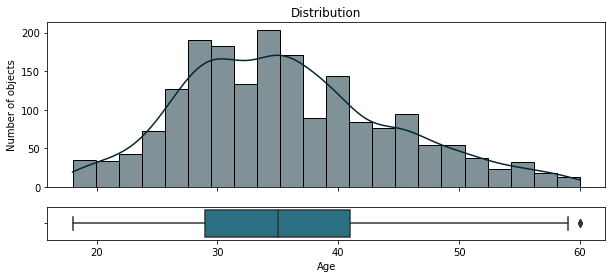

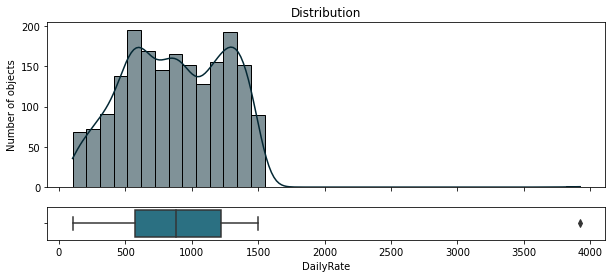

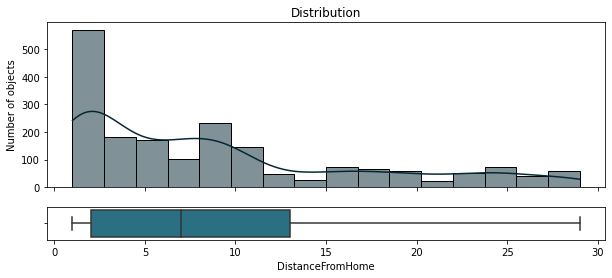

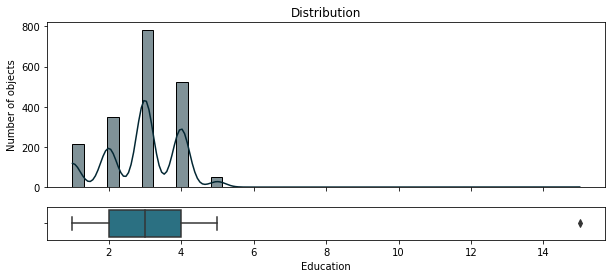

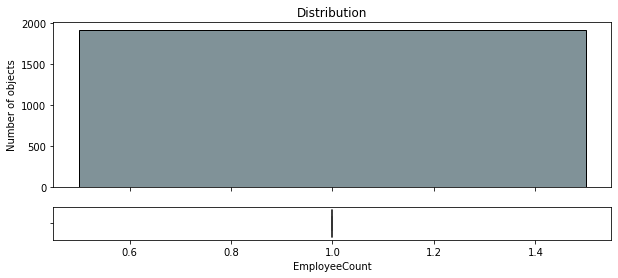

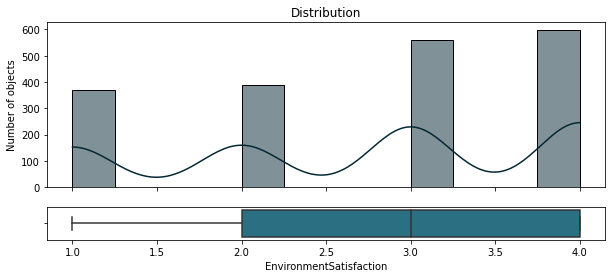

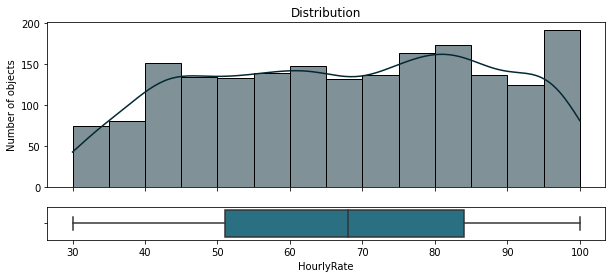

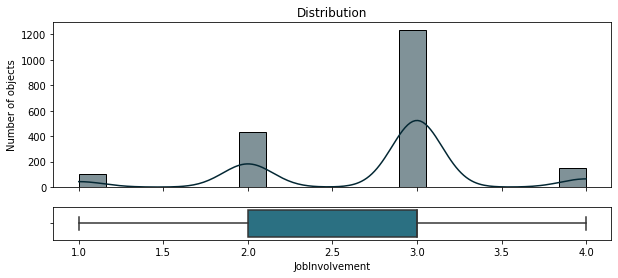

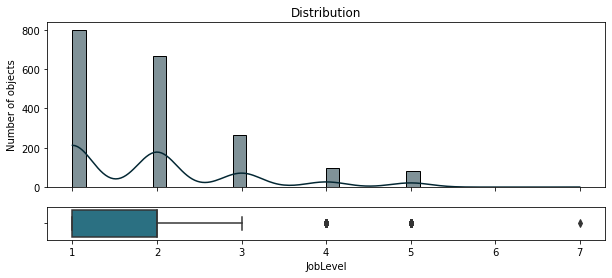

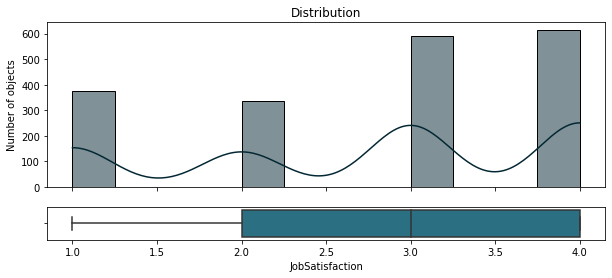

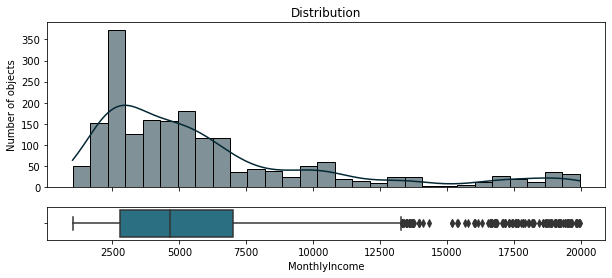

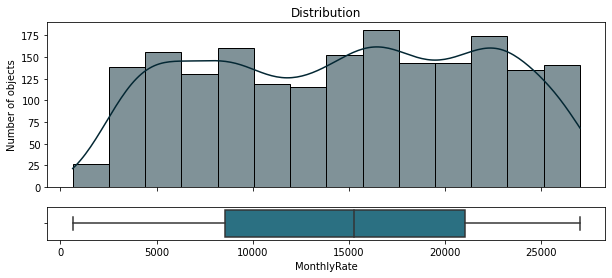

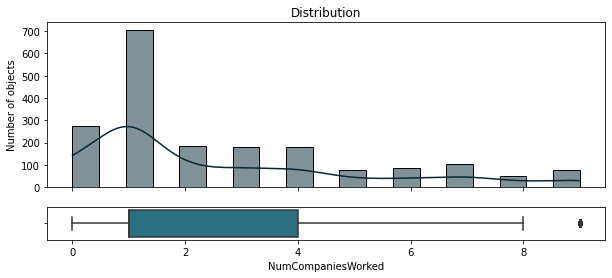

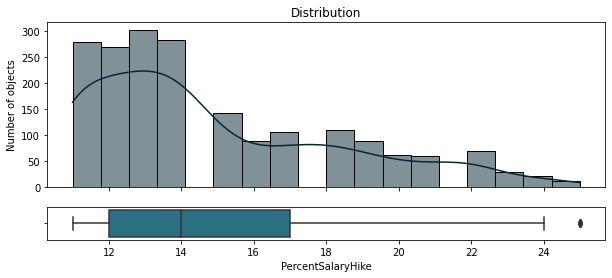

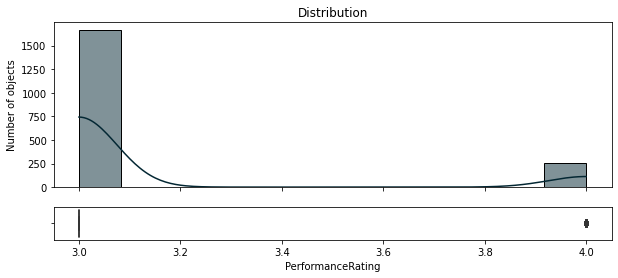

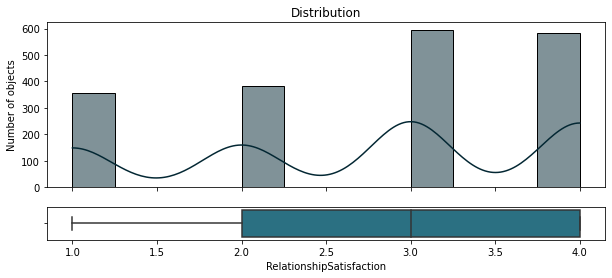

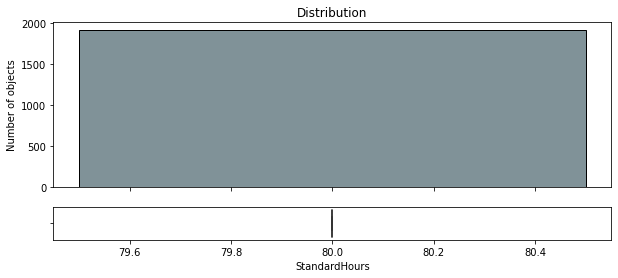

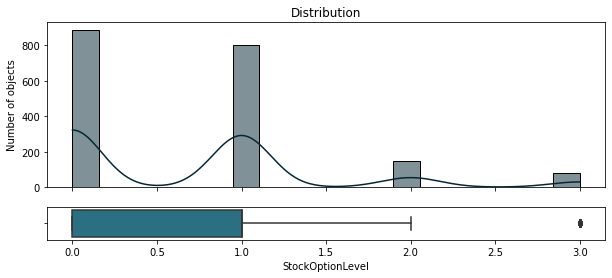

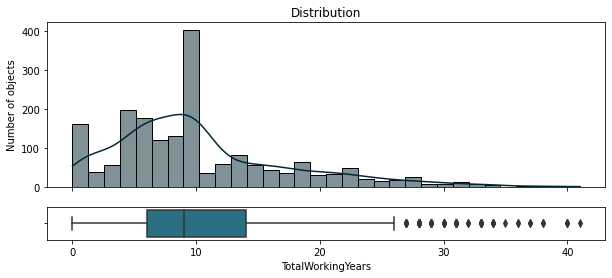

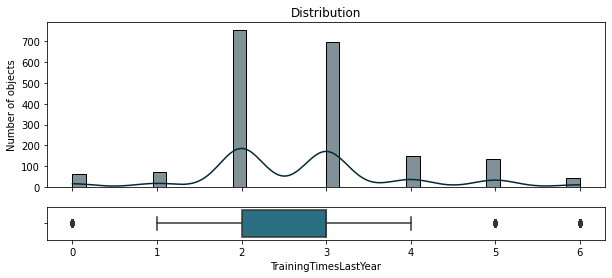

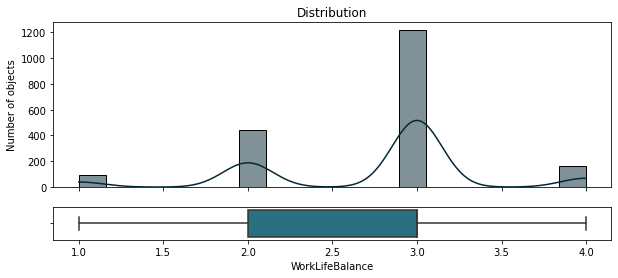

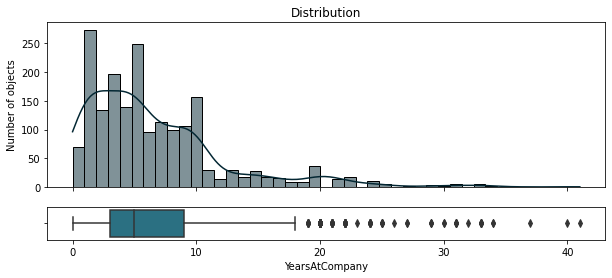

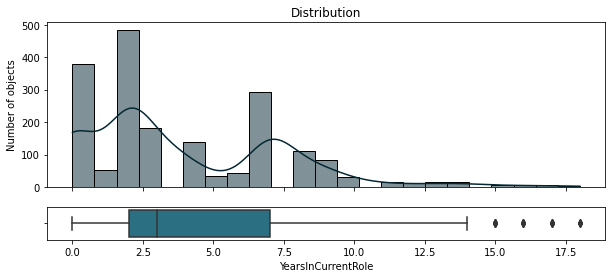

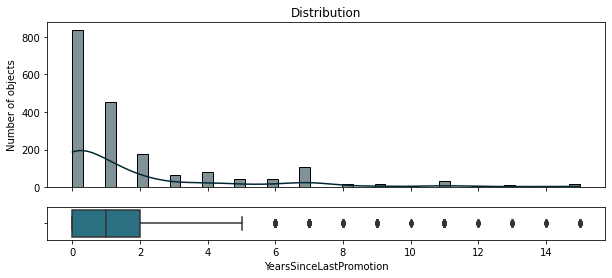

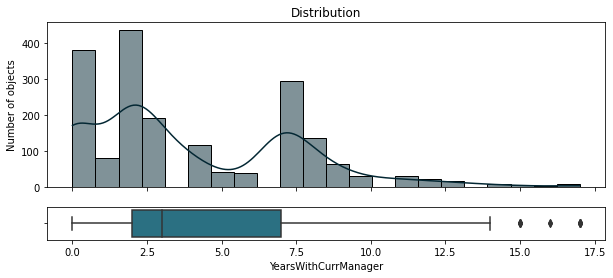

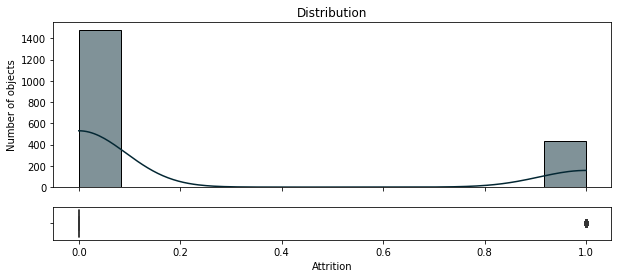

In [11]:
for col in train.select_dtypes(include='number').columns:
    make_boxplot(train, col)

In [12]:
drop_cols = ['EmployeeCount', 'Over18', 'StandardHours']
for col in train.select_dtypes(include='object'): 
    display(make_table_rote_target(train, col, 'Attrition'))

,sum,count,share
BusinessTravel,,,
Travel_Frequently,120,330,0.363636
Travel_Rarely,300,1446,0.207469
Non-Travel,17,138,0.123188


,sum,count,share
Department,,,
Human Resources,19,51,0.372549
Sales,159,563,0.282416
Research & Development,259,1300,0.199231


,sum,count,share
EducationField,,,
Human Resources,10,20,0.500000
Technical Degree,46,138,0.333333
Marketing,61,187,0.326203
Medical,126,612,0.205882
Life Sciences,177,864,0.204861
Other,17,93,0.182796


,sum,count,share
Gender,,,
Male,288,1214,0.237232
Female,149,700,0.212857


,sum,count,share
JobRole,,,
Sales Representative,59,110,0.536364
Human Resources,19,46,0.413043
Laboratory Technician,123,396,0.310606
Sales Executive,95,412,0.230583
Research Scientist,89,391,0.227621
Manager,14,116,0.120690
Healthcare Representative,19,164,0.115854
Manufacturing Director,15,206,0.072816
Research Director,4,73,0.054795


,sum,count,share
MaritalStatus,,,
Single,234,697,0.335725
Married,154,857,0.179697
Divorced,49,360,0.136111


,sum,count,share
Over18,,,
Y,437,1914,0.228318


,sum,count,share
OverTime,,,
Yes,215,527,0.407970
No,222,1387,0.160058


In [13]:
for col in list(set(train.select_dtypes(include='number'))-set(drop_cols)):
    make_plot_distribution(train, col, 'Attrition')

### <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:120%; text-align:left; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 5px 5px;">2.3. Feature correlation</p>

In [14]:
train.drop(drop_cols, axis=1).corr().style.background_gradient(low=0.1, cmap='BrBG')

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
Age,1.000000,0.046188,-0.043954,0.220837,0.028673,0.045517,0.024815,0.484958,0.005368,0.476331,0.000519,0.301226,-0.055568,-0.025418,0.070369,0.084666,0.654092,0.006548,0.020564,0.332549,0.247492,0.221404,0.226287,-0.170182
DailyRate,0.046188,1.000000,-0.000527,-0.008323,0.013602,0.014368,-0.001080,0.051702,-0.019499,0.039011,-0.028085,-0.007989,-0.025858,-0.043503,-0.001156,0.023180,0.063540,-0.018208,0.031878,0.058601,0.059478,0.023196,0.048247,-0.100034
DistanceFromHome,-0.043954,-0.000527,1.000000,-0.006723,-0.000169,0.000418,0.003942,-0.043843,0.008562,-0.057923,0.018908,-0.039910,0.052738,0.050322,-0.008158,0.030305,-0.037383,-0.008534,-0.028352,-0.031682,-0.019977,-0.004864,0.000799,0.072480
Education,0.220837,-0.008323,-0.006723,1.000000,-0.011707,0.017094,0.064151,0.091500,-0.033006,0.086085,0.006009,0.086366,-0.021021,0.006910,0.007452,0.047634,0.157740,-0.017778,-0.021529,0.123990,0.098125,0.061789,0.114975,-0.078845
EnvironmentSatisfaction,0.028673,0.013602,-0.000169,-0.011707,1.000000,0.009181,0.037837,0.019241,-0.027612,0.018448,-0.006342,-0.063487,-0.031596,-0.046533,-0.026505,-0.001353,0.021395,-0.017003,0.026818,0.020331,0.025609,0.039162,0.030788,-0.122433
HourlyRate,0.045517,0.014368,0.000418,0.017094,0.009181,1.000000,0.013196,-0.010329,-0.033499,-0.007997,-0.017719,0.049008,0.003821,0.009651,-0.025201,0.043831,-0.013655,0.043557,0.005111,-0.048996,-0.057234,-0.066576,-0.062080,-0.051041
JobInvolvement,0.024815,-0.001080,0.003942,0.064151,0.037837,0.013196,1.000000,0.018097,0.035267,0.013783,-0.006650,-0.013930,0.042890,0.004180,0.022118,0.041705,0.017567,-0.024394,0.020979,0.005394,0.019333,0.018487,0.027412,-0.180763
JobLevel,0.484958,0.051702,-0.043843,0.091500,0.019241,-0.010329,0.018097,1.000000,-0.005221,0.913929,0.041480,0.116685,-0.105782,-0.064158,0.030750,0.033766,0.762439,-0.033484,0.016342,0.541831,0.421642,0.386607,0.415749,-0.170483
JobSatisfaction,0.005368,-0.019499,0.008562,-0.033006,-0.027612,-0.033499,0.035267,-0.005221,1.000000,-0.011316,0.010154,-0.006871,-0.016314,-0.003796,0.030940,0.027923,-0.018497,0.013763,-0.002040,0.011729,-0.002722,0.012506,-0.009834,-0.107674
MonthlyIncome,0.476331,0.039011,-0.057923,0.086085,0.018448,-0.007997,0.013783,0.913929,-0.011316,1.000000,0.045968,0.110360,-0.113073,-0.075149,0.036422,0.028602,0.742658,-0.035199,0.010315,0.548196,0.413287,0.387866,0.404901,-0.159502


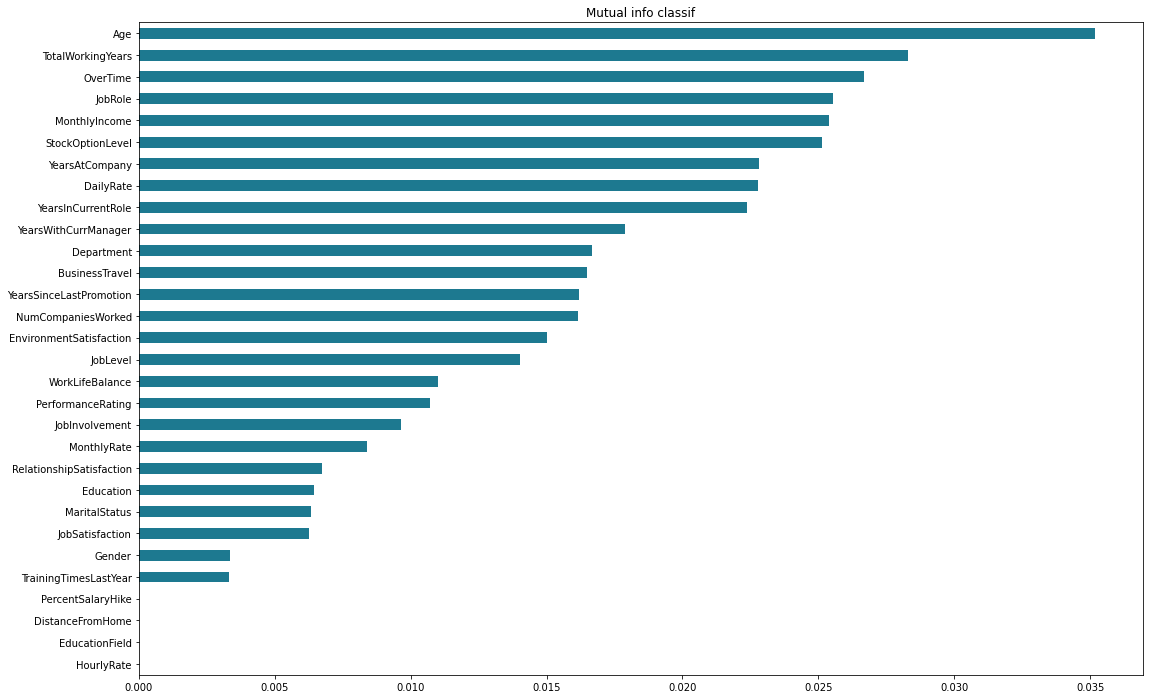

In [15]:
X = train.copy().drop(drop_cols, axis=1)
y = X.pop('Attrition')

for col in list(X.select_dtypes(include=['object', 'category']).columns):
    X[col], _ = X[col].factorize()
scores = pd.Series(mutual_info_classif(X, y), index=X.columns).sort_values()
scores.plot(kind='barh', figsize = (18,12), color=palitra['blue'])
plt.title('Mutual info classif');

## <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:150%; text-align:center; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 25px 5px;">3. Datasets creation</p>

In [16]:
def make_features(df):
    df_new = df.copy()
    for col in list(df_new.select_dtypes(include='object').columns):
        df_new[col] = df_new[col].astype('category')  
    df_new = df_new.drop(drop_cols, axis=1)
    return df_new

def make_woe_encoder(X):
    woe_encoder = WoEEncoder(variables=cat_features) 
    woe_encoder.fit(X_df, y_df)
    X = woe_encoder.transform(X)
    return X

def make_my_pipline(df):
    new_df = make_woe_encoder(df.copy())
    new_df[numeric_features] = StandardScaler().fit(new_df[numeric_features]).transform(new_df[numeric_features])
    return new_df

In [17]:
train_df = make_features(train)
test_df = make_features(test)
X_df = train_df.drop('Attrition', axis=1)
y_df = train_df[['Attrition']]
X_df.shape, test_df.shape

((1914, 30), (1119, 30))

In [18]:
numeric_features = list(test_df.select_dtypes(include='number').columns)
cat_features = list(test_df.select_dtypes(include='category').columns)
numeric_features, cat_features

(['Age',
  'DailyRate',
  'DistanceFromHome',
  'Education',
  'EnvironmentSatisfaction',
  'HourlyRate',
  'JobInvolvement',
  'JobLevel',
  'JobSatisfaction',
  'MonthlyIncome',
  'MonthlyRate',
  'NumCompaniesWorked',
  'PercentSalaryHike',
  'PerformanceRating',
  'RelationshipSatisfaction',
  'StockOptionLevel',
  'TotalWorkingYears',
  'TrainingTimesLastYear',
  'WorkLifeBalance',
  'YearsAtCompany',
  'YearsInCurrentRole',
  'YearsSinceLastPromotion',
  'YearsWithCurrManager'],
 ['BusinessTravel',
  'Department',
  'EducationField',
  'Gender',
  'JobRole',
  'MaritalStatus',
  'OverTime'])

In [19]:
models_results = {
            'model': [],
            'rocauc_val': []}

## <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:150%; text-align:center; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 25px 5px;">4. Selection of hyperparameters</p>

In [20]:
X_df_pl = make_my_pipline(X_df)
X_test_pl = make_my_pipline(test_df)

X_train, X_val, y_train, y_val = train_test_split(X_df_pl, y_df, test_size=.25, random_state=random_state)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1435, 30), (479, 30), (1435, 1), (479, 1))

### <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:120%; text-align:left; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 5px 5px;">4.1. Catboost</p>

In [21]:
# fit_params = dict(early_stopping_rounds = 20,
#                   eval_set = [(X_train, y_train), (X_val, y_val)], 
#                   verbose = False)
# cbc = CatBoostClassifier(random_state=random_state
#                          , auto_class_weights='Balanced')
# parameters = {'depth': range(1,7,1),
#               'learning_rate': [.01, .1],
#               'iterations': range(20,501,20),
#               'l2_leaf_reg': [2,3,4]}
# grid_cbc = RandomizedSearchCV(cbc, parameters, scoring='roc_auc', cv=5)
# grid_cbc.fit(X_train, y_train, **fit_params)
# grid_cbc.best_params_

In [22]:
params_cbc = {'learning_rate': 0.1, 'l2_leaf_reg': 4, 'iterations': 500, 'depth': 1}

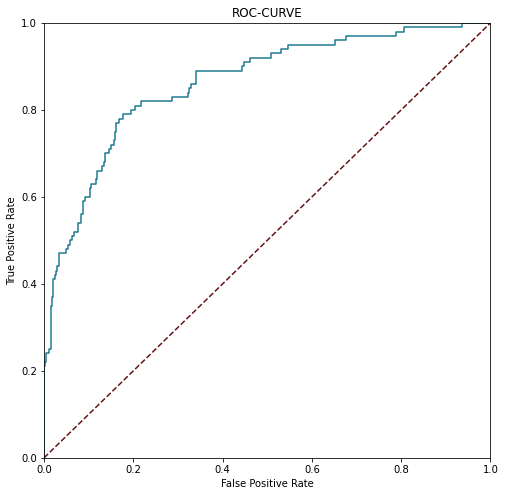

ROC-AUC: 0.8621635883905013


In [23]:
# best_cbc = grid_cbc.best_estimator_
best_cbc = CatBoostClassifier(random_state=random_state
                         , auto_class_weights='Balanced', **params_cbc)
best_cbc.fit(X_train, y_train, verbose=False)
pred = best_cbc.predict(X_val)
pred_prob = best_cbc.predict_proba(X_val)[:,1]

models_results['rocauc_val'].append(roc_auc_score(y_val, pred_prob))
models_results['model'].append('Catboost')

make_roc_curve(y_val, pred_prob)

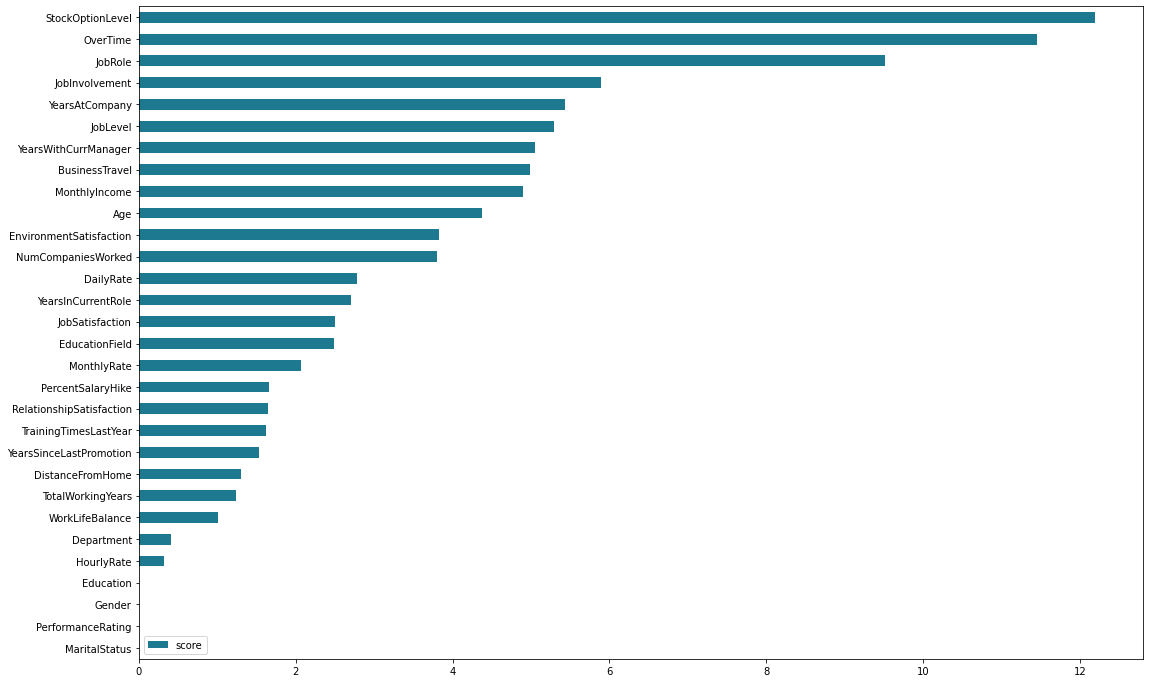

In [24]:
cbc = pd.DataFrame(data=best_cbc.feature_importances_, index=best_cbc.feature_names_, columns=['score']
                  ).sort_values(by='score')
cbc.plot(kind='barh', figsize = (18,12), color=palitra['blue']); 

### <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:120%; text-align:left; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 5px 5px;">4.2. LGBM</p>

In [25]:
# fit_params = dict(early_stopping_rounds = 20,
#                   eval_set = [(X_train, y_train), (X_val, y_val)], 
#                   eval_metric='AUC',
#                   verbose = 1000)
# params = {'n_estimators': range(20, 1001, 20),
#           'learning_rate': [0.01, 0.1],
#           'max_depth': range(-1, 36, 1),
#           'num_leaves': range(1, 200, 1),
#           'boosting_type': ['gbdt', 'dart', 'goss']       
#          }
# lgbm = LGBMClassifier(random_state=random_state, class_weight='balanced')
# grid_lgbm = RandomizedSearchCV(lgbm, params, scoring='roc_auc', cv=5)
# grid_lgbm.fit(X_train, y_train, **fit_params)
# grid_lgbm.best_params_

In [26]:
params_lgbm = {'num_leaves': 149, 'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.1, 'boosting_type': 'goss'}

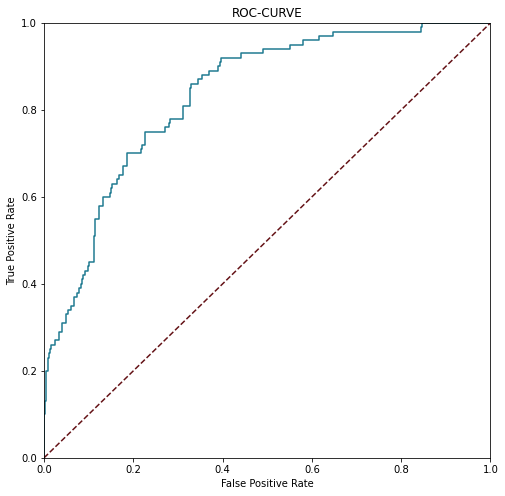

ROC-AUC: 0.8344591029023747


In [27]:
# best_lgbm = grid_lgbm.best_estimator_
best_lgbm = LGBMClassifier(random_state=random_state, class_weight='balanced', **params_lgbm)
best_lgbm.fit(X_train, y_train)
pred = best_lgbm.predict(X_val)
pred_prob = best_lgbm.predict_proba(X_val)[:,1]

models_results['rocauc_val'].append(roc_auc_score(y_val, pred_prob))
models_results['model'].append('LGBM')

make_roc_curve(y_val, pred_prob)

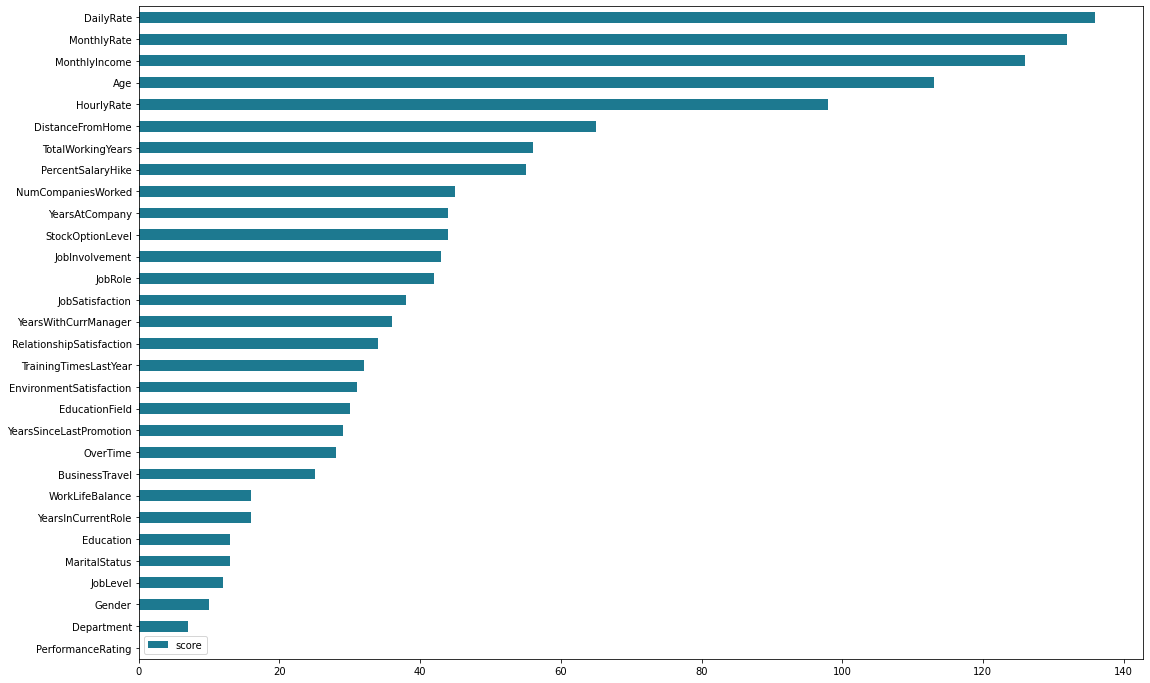

In [28]:
lgb = pd.DataFrame(data=best_lgbm.feature_importances_, index=best_lgbm.feature_name_, columns=['score']
                  ).sort_values(by='score')
lgb.plot(kind='barh', figsize = (18,12), color=palitra['blue']); 

### <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:120%; text-align:left; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 5px 5px;">4.3. XGBoost</p>

In [29]:
# fit_params = dict(early_stopping_rounds = 20,
#                   eval_set = [(X_train, y_train), (X_val, y_val)], 
#                   verbose = False)
# params = {'n_estimators': range(20, 1001, 20),
#           'learning_rate': [0.01, 0.1],
#           'max_depth': range(-1, 36, 1),
#           'num_leaves': range(1, 200, 1),
#           'boosting_type': ['gbdt', 'dart', 'goss']       
#          }
# xgb = XGBClassifier(random_state=random_state, class_weight='balanced')
# grid_xgb = RandomizedSearchCV(xgb, params, scoring='roc_auc', cv=5)
# grid_xgb.fit(X_train, y_train, **fit_params)
# grid_xgb.best_params_

In [30]:
params_xgb = {'num_leaves': 155, 'n_estimators': 780, 'max_depth': 1, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}

[03:09:54] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting_type", "class_weight", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




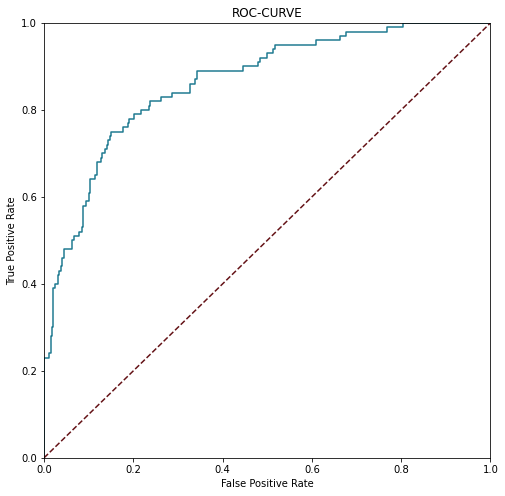

ROC-AUC: 0.8640633245382586


In [31]:
# best_xgb = grid_xgb.best_estimator_
best_xgb = XGBClassifier(random_state=random_state, class_weight='balanced', **params_xgb)
best_xgb.fit(X_train, y_train)
pred = best_xgb.predict(X_val)
pred_prob = best_xgb.predict_proba(X_val)[:,1]

models_results['rocauc_val'].append(roc_auc_score(y_val, pred_prob))
models_results['model'].append('XGBClassifier')

make_roc_curve(y_val, pred_prob)

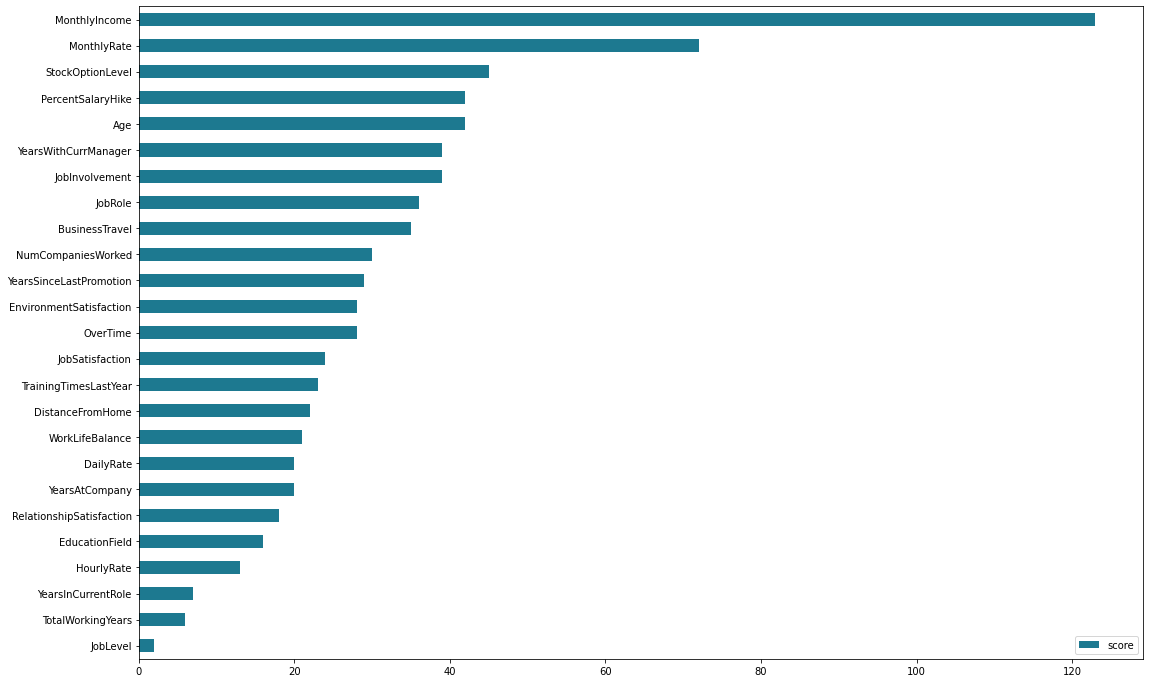

In [32]:
feature_important = best_xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

xgb = pd.DataFrame(data=values, index=keys, columns=['score']).sort_values(by='score')
xgb.plot(kind='barh', figsize = (18,12), color=palitra['blue']);

### <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:120%; text-align:left; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 5px 5px;">4.4. RandomForest</p>

In [33]:
# params = {'n_estimators': range(1, 1001, 100),
#           'max_depth': range(1, 24, 1)}
# rfc = RandomForestClassifier(random_state=random_state, class_weight='balanced')
# grid_rfc = RandomizedSearchCV(rfc, params, scoring='roc_auc', cv=5)
# grid_rfc.fit(X_train, y_train)
# grid_rfc.best_params_

In [34]:
params_rfc = {'n_estimators': 701, 'max_depth': 20}

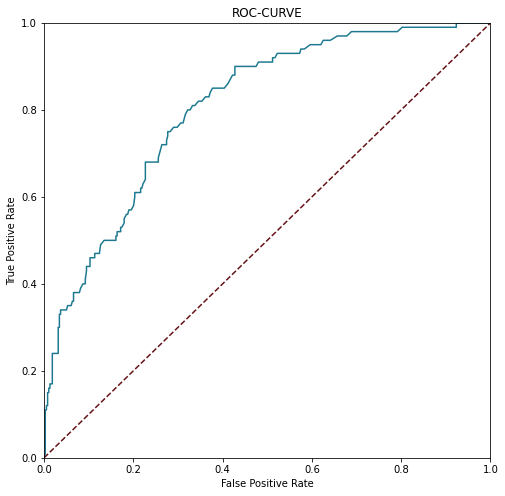

ROC-AUC: 0.8076121372031662


In [35]:
# best_rfc = grid_rfc.best_estimator_
best_rfc = RandomForestClassifier(random_state=random_state, class_weight='balanced', **params_rfc)
best_rfc.fit(X_train, y_train)
pred = best_rfc.predict(X_val)
pred_prob = best_rfc.predict_proba(X_val)[:,1]

models_results['rocauc_val'].append(roc_auc_score(y_val, pred_prob))
models_results['model'].append('RandomForest')

make_roc_curve(y_val, pred_prob)

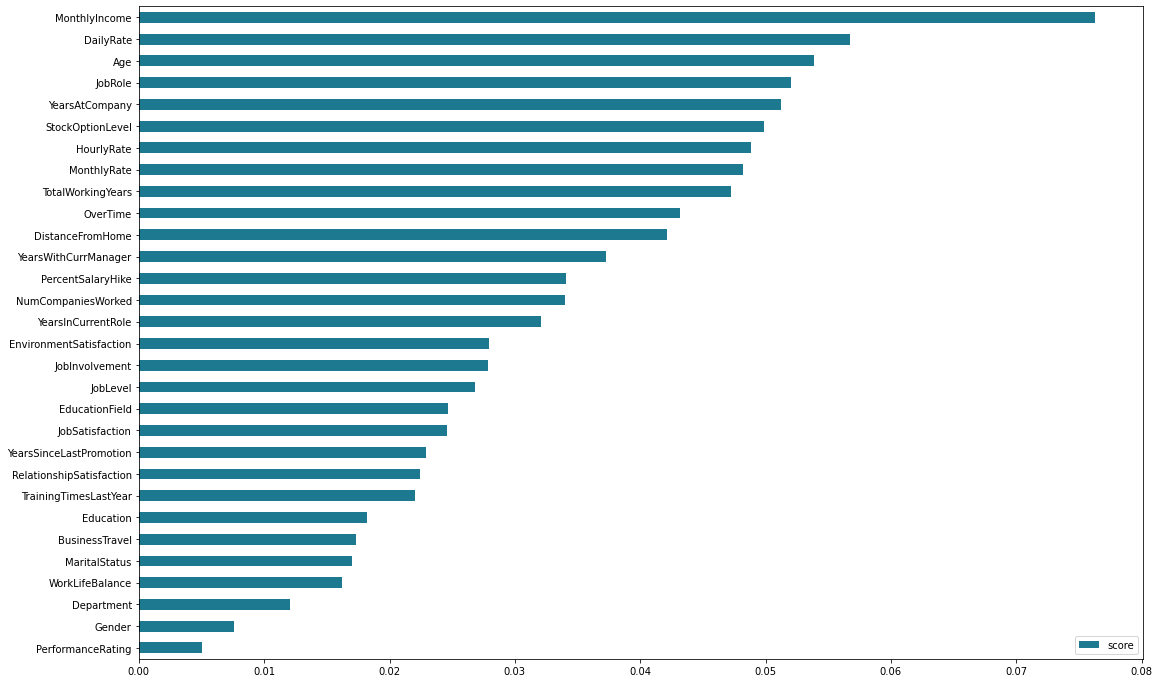

In [36]:
rfc = pd.DataFrame(data=best_rfc.feature_importances_, index=best_rfc.feature_names_in_, columns=['score']
                  ).sort_values(by='score')
rfc.plot(kind='barh', figsize = (18,12), color=palitra['blue']); 

### <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:120%; text-align:left; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 5px 5px;">4.5. Ensemble</p>

In [37]:
best_cbc.fit(X_train, y_train, verbose=False)
best_lgbm.fit(X_train, y_train, verbose=False)
best_xgb.fit(X_train, y_train, verbose=False)
ens_pred_prob = np.column_stack([best_cbc.predict_proba(X_val)[:,1], 
                                 best_xgb.predict_proba(X_val)[:,1],
                                 best_lgbm.predict_proba(X_val)[:,1]]
                               ).mean(axis=1)
models_results['rocauc_val'].append(roc_auc_score(y_val, ens_pred_prob))
models_results['model'].append(f'Ensemble')

[03:10:00] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting_type", "class_weight", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




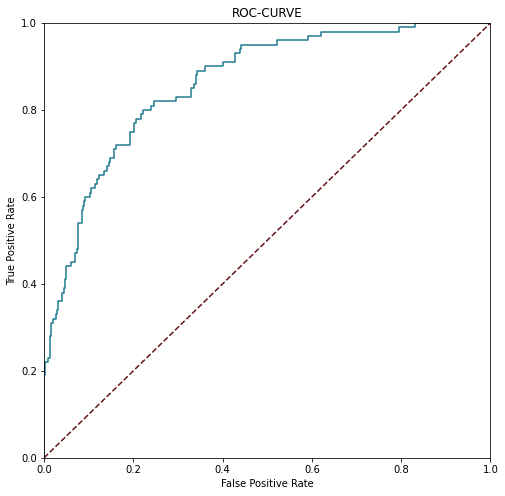

ROC-AUC: 0.8622691292875989


In [38]:
make_roc_curve(y_val, ens_pred_prob)

## <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:150%; text-align:center; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 25px 5px;">5. Removing features</p>

In [39]:
def feat_del(drop_list, df):
    new_df = df.copy()
    new_df = new_df.drop(drop_list, axis=1)
    return new_df

In [40]:
drop_list = list(set(lgb.index)-set(xgb.index))
X_df_pl_del = feat_del(drop_list, X_df_pl)
X_test_pl_del = feat_del(drop_list, X_test_pl)
X_train, X_val, y_train, y_val = train_test_split(X_df_pl_del, y_df, test_size=.25, random_state=random_state)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1435, 25), (479, 25), (1435, 1), (479, 1))

### <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:120%; text-align:left; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 5px 5px;">5.1. Catboost</p>

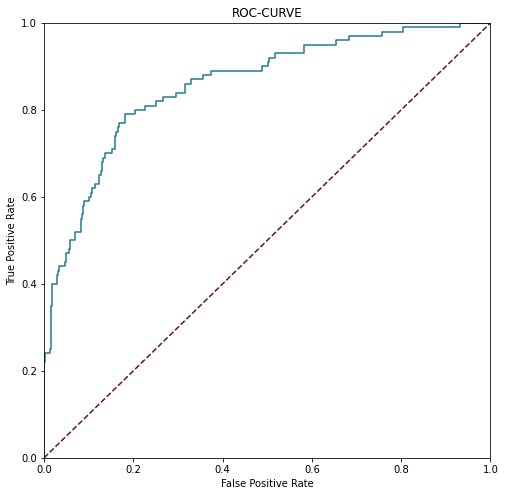

ROC-AUC: 0.8579419525065963


In [41]:
best_cbc.fit(X_train, y_train, verbose=False)
pred = best_cbc.predict(X_val)
pred_prob = best_cbc.predict_proba(X_val)[:,1]

models_results['rocauc_val'].append(roc_auc_score(y_val, pred_prob))
models_results['model'].append(f'Catboost_without_{drop_list}')

make_roc_curve(y_val, pred_prob)

### <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:120%; text-align:left; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 5px 5px;">5.2. LGBM</p>

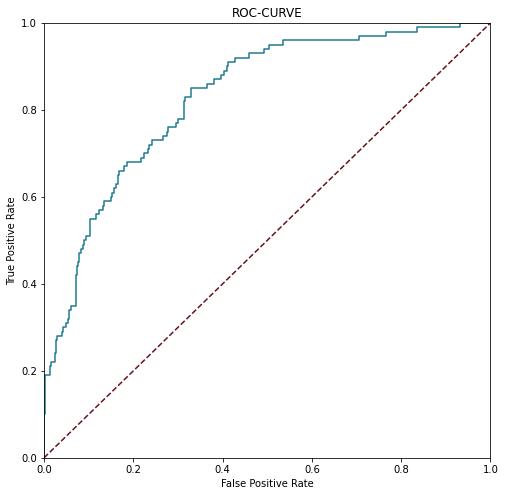

ROC-AUC: 0.8296569920844327


In [42]:
best_lgbm.fit(X_train, y_train)
pred = best_lgbm.predict(X_val)
pred_prob = best_lgbm.predict_proba(X_val)[:,1]

models_results['rocauc_val'].append(roc_auc_score(y_val, pred_prob))
models_results['model'].append(f'LGBM_without_{drop_list}')

make_roc_curve(y_val, pred_prob)

### <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:120%; text-align:left; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 5px 5px;">5.3. XGBClassifier</p>

[03:10:03] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting_type", "class_weight", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




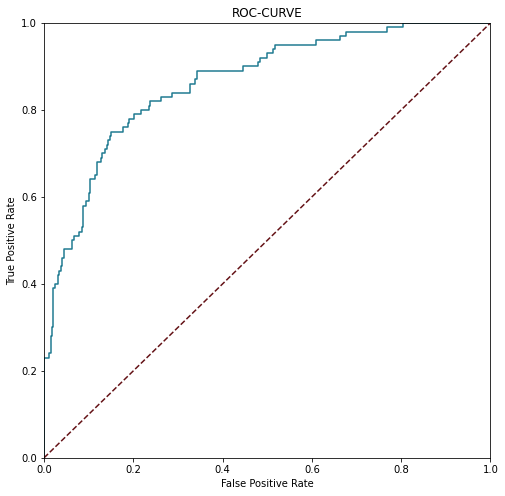

ROC-AUC: 0.8640633245382586


In [43]:
best_xgb.fit(X_train, y_train)
pred = best_xgb.predict(X_val)
pred_prob = best_xgb.predict_proba(X_val)[:,1]

models_results['rocauc_val'].append(roc_auc_score(y_val, pred_prob))
models_results['model'].append(f'XGBClassifier_without_{drop_list}')

make_roc_curve(y_val, pred_prob)

### <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:120%; text-align:left; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 5px 5px;">5.3. RandomForest</p>

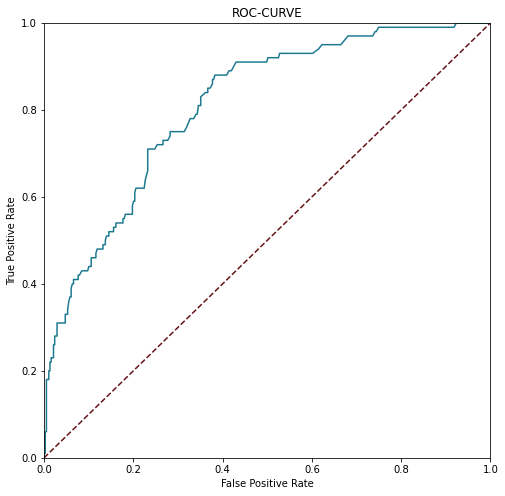

ROC-AUC: 0.8100131926121371


In [44]:
best_rfc.fit(X_train, y_train)
pred = best_rfc.predict(X_val)
pred_prob = best_rfc.predict_proba(X_val)[:,1]

models_results['rocauc_val'].append(roc_auc_score(y_val, pred_prob))
models_results['model'].append(f'RandomForest_without_{drop_list}')

make_roc_curve(y_val, pred_prob)

### <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:120%; text-align:left; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 5px 5px;">5.5. Ensemble</p>

In [45]:
best_cbc.fit(X_train, y_train, verbose=False)
best_lgbm.fit(X_train, y_train, verbose=False)
best_xgb.fit(X_train, y_train, verbose=False)
ens_pred_prob = np.column_stack([best_cbc.predict_proba(X_val)[:,1], 
                                 best_xgb.predict_proba(X_val)[:,1],
                                 best_lgbm.predict_proba(X_val)[:,1]]
                               ).mean(axis=1)
models_results['rocauc_val'].append(roc_auc_score(y_val, ens_pred_prob))
models_results['model'].append(f'Ensemble_{drop_list}')

[03:10:08] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting_type", "class_weight", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




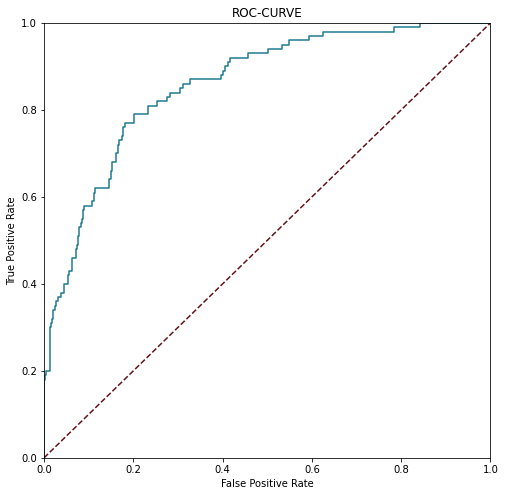

ROC-AUC: 0.8586015831134565


In [46]:
make_roc_curve(y_val, ens_pred_prob)

## <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:150%; text-align:center; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 25px 5px;">6. Best Model Submission</p>

In [47]:
pd.DataFrame(data=models_results).sort_values(by='rocauc_val', ascending=False).style.background_gradient(low=0.1, cmap='BrBG')

,model,rocauc_val
2,XGBClassifier,0.864063
7,"XGBClassifier_without_['PerformanceRating', 'MaritalStatus', 'Gender', 'Department', 'Education']",0.864063
4,Ensemble,0.862269
0,Catboost,0.862164
9,"Ensemble_['PerformanceRating', 'MaritalStatus', 'Gender', 'Department', 'Education']",0.858602
5,"Catboost_without_['PerformanceRating', 'MaritalStatus', 'Gender', 'Department', 'Education']",0.857942
1,LGBM,0.834459
6,"LGBM_without_['PerformanceRating', 'MaritalStatus', 'Gender', 'Department', 'Education']",0.829657
8,"RandomForest_without_['PerformanceRating', 'MaritalStatus', 'Gender', 'Department', 'Education']",0.810013
3,RandomForest,0.807612


In [48]:
best_xgb.fit(X_df_pl_del, y_df, verbose=False)
submission['Attrition'] = best_xgb.predict_proba(X_test_pl_del)[:,1]                                          
submission.to_csv('submission.csv', index = False)

[03:10:09] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting_type", "class_weight", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


